In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [2]:
data = pd.read_csv("glove_emg1.csv")

In [3]:
data.head()

,Channel_1,Channel_2,Channel_3,Channel_4,Channel_5,Channel_6,Channel_7,Channel_8,Thumb,Index,Middle,Ring,Pinky
0,0,-1,-5,-4,3,7,3,1,0,1,2,3,4
1,0,-3,0,2,-3,1,0,0,0,1,2,3,4
2,-2,-2,-2,-3,-4,-9,-4,-2,0,1,2,3,4
3,-1,0,-4,-2,1,0,0,-1,0,1,2,3,4
4,1,3,6,1,2,-1,-1,-2,0,1,2,3,4


In [4]:
finger_names = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
myo_cols = ["Channel_1", "Channel_2", "Channel_3", "Channel_4", "Channel_5", "Channel_6", "Channel_7", "Channel_8"]

In [5]:
df = data.copy(deep=True)

<AxesSubplot:>

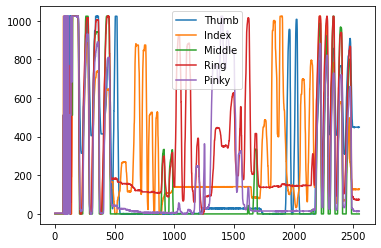

In [6]:
df[finger_names].plot()

<AxesSubplot:>

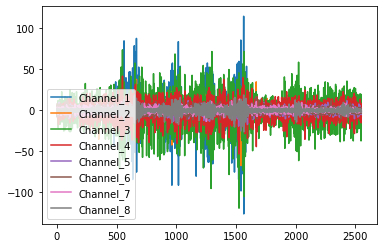

In [7]:
df[myo_cols].plot()

In [8]:
print("Correlation Matrix")
print()

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df, 10))

Correlation Matrix

Top Absolute Correlations
Middle     Ring         0.766536
Thumb      Middle       0.747582
Channel_1  Channel_8    0.699846
Middle     Pinky        0.692025
Ring       Pinky        0.673060
Channel_3  Channel_4    0.619397
Channel_1  Channel_2    0.612738
Channel_6  Channel_7    0.592636
Index      Middle       0.588362
Channel_5  Channel_6    0.578235
dtype: float64


# Making a full hand baseline

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

x_cols = ['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4', 'Channel_5',
       'Channel_6', 'Channel_7', 'Channel_8']

X = df[x_cols]
y = df.drop(x_cols,1)

train_X, test_X, train_y, test_y = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.25)

# Making our benchmark model
# Just predict the mean average number of bikes. 
y_train_mean = train_y.mean()

train_preds = np.ones(train_y.shape) * y_train_mean
preds = np.ones(test_y.shape) * y_train_mean

rmse = np.sqrt(mean_squared_error(train_y, train_preds))
print("Train RMSE: %f" % (rmse))

mae = mean_absolute_error(train_y, train_preds)
print("Train MAE: %f" % (mae))

rmse = np.sqrt(mean_squared_error(test_y, preds))
print("Test RMSE: %f" % (rmse))

mae = mean_absolute_error(test_y, preds)
print("Test MAE: %f" % (mae))

r2_score(test_y, preds)

Train RMSE: 324.244810
Train MAE: 267.728299
Test RMSE: 322.760607
Test MAE: 267.104992


-0.042935612702566184

In [10]:
X

,Channel_1,Channel_2,Channel_3,Channel_4,Channel_5,Channel_6,Channel_7,Channel_8
0,0,-1,-5,-4,3,7,3,1
1,0,-3,0,2,-3,1,0,0
2,-2,-2,-2,-3,-4,-9,-4,-2
3,-1,0,-4,-2,1,0,0,-1
4,1,3,6,1,2,-1,-1,-2
...,...,...,...,...,...,...,...,...
2545,2,8,19,8,1,1,0,1
2546,-6,-17,11,5,-4,-3,-3,-3
2547,-2,2,-38,-9,-6,-2,-3,-3
2548,4,18,14,-16,1,1,-2,0


In [11]:
y

,Thumb,Index,Middle,Ring,Pinky
0,0,1,2,3,4
1,0,1,2,3,4
2,0,1,2,3,4
3,0,1,2,3,4
4,0,1,2,3,4
...,...,...,...,...,...
2545,449,126,0,73,12
2546,449,126,0,73,12
2547,449,126,0,75,15
2548,449,126,0,75,15


# Making a baseline Neural Network

In [12]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [140]:
finger_names = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
myo_cols = ["Channel_1", "Channel_2", "Channel_3", "Channel_4", "Channel_5", "Channel_6", "Channel_7", "Channel_8"]
x_cols = myo_cols
y_cols = finger_names

df = pd.read_csv("glove_emg1.csv")

# Get rid of the first garbage readings
df = df.iloc[50:]

# Rectification
X = abs(df[x_cols]).values
y = df.drop(x_cols,1).values

# Scaling
X = X/128
y = y/1024

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25)

In [141]:
model = Sequential()

# The Input Layer :
model.add(Dense(16,input_dim = train_X.shape[1], activation='relu'))

# The Hidden Layers :
model.add(Dense(32,activation='relu'))
model.add(Dense(64,activation='relu'))

# The Output Layer :
model.add(Dense(5,activation='relu'))

# Compile the network :
model.compile(loss='mse', optimizer='Adam')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_17 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_18 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_19 (Dense)             (None, 5)                 325       
Total params: 3,125
Trainable params: 3,125
Non-trainable params: 0
_________________________________________________________________


In [142]:
history = model.fit(train_X, train_y, epochs=20, batch_size=32, validation_data=(test_X, test_y))

Epoch 1/20
59/59 [==============================] - 1s 6ms/step - loss: 0.1379 - val_loss: 0.1182
Epoch 2/20
59/59 [==============================] - 0s 3ms/step - loss: 0.1180 - val_loss: 0.0934
Epoch 3/20
59/59 [==============================] - 0s 3ms/step - loss: 0.0917 - val_loss: 0.0918
Epoch 4/20
59/59 [==============================] - 0s 3ms/step - loss: 0.0942 - val_loss: 0.0920
Epoch 5/20
59/59 [==============================] - 0s 3ms/step - loss: 0.0953 - val_loss: 0.0912
Epoch 6/20
59/59 [==============================] - 0s 3ms/step - loss: 0.0913 - val_loss: 0.0914
Epoch 7/20
59/59 [==============================] - 0s 3ms/step - loss: 0.0910 - val_loss: 0.0915
Epoch 8/20
59/59 [==============================] - 0s 3ms/step - loss: 0.0951 - val_loss: 0.0912
Epoch 9/20
59/59 [==============================] - 0s 3ms/step - loss: 0.0893 - val_loss: 0.0911
Epoch 10/20
59/59 [==============================] - 0s 3ms/step - loss: 0.0887 - val_loss: 0.0912
Epoch 11/20
59/59 [

In [143]:
# Evaluate the model on the test data
mse = model.evaluate(test_X, test_y)
mse

20/20 [==============================] - 0s 1ms/step - loss: 0.0910


0.0910358801484108

Note that using wrist as the rel_point gives 0.10, which was a lower loss than using the palm

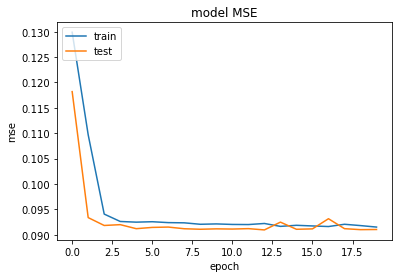

In [144]:
# summarize history for loss
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model MSE')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [145]:
# Training Set
train_preds = model.predict(train_X) # scaled inputs here

# Scaling back the prediction
train_preds = train_preds * 1024
# Scaling back the goals
train_goal = train_y * 1024

MSE = mean_squared_error(train_goal, train_preds)  # first 2 steps, combined
print("Train MSE: ", MSE)
print("Train RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(train_goal, train_preds)
print("Train MAE: ", MAE)

print()
# Test Set
test_preds = model.predict(test_X) # scaled inputs here

# Scaling back the prediction
test_preds = test_preds * 1024
# Scaling back the goals
test_goal = test_y * 1024

MSE = mean_squared_error(test_goal, test_preds)  # first 2 steps, combined
print("Test MSE: ", MSE)
print("Test RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(test_goal, test_preds)
print("Test MAE: ", MAE)

Train MSE:  95575.40763044944
Train RMSE:  309.1527254132647
Train MAE:  246.62612197713216

Test MSE:  95458.03590014974
Test RMSE:  308.962839027851
Test MAE:  245.70157350097656


In [146]:
train_preds_df = pd.DataFrame(train_preds, columns=y_cols)
train_goals_df = pd.DataFrame(train_goal, columns=y_cols)

# Plot the predicted vs ground truth

In [155]:
y_cols_pred = []
for i in y_cols:
    y_cols_pred.append(i+"_pred")
    
preds = pd.DataFrame(train_preds, columns=y_cols_pred)
goal = pd.DataFrame(train_goal, columns=y_cols)
vis = pd.concat([preds, goal], axis=1)

In [156]:
vis

,Thumb_pred,Index_pred,Middle_pred,Ring_pred,Pinky_pred,Thumb,Index,Middle,Ring,Pinky
0,284.195435,397.246002,206.623672,362.777588,248.025436,1023.0,660.0,511.0,1023.0,1023.0
1,277.905487,387.711273,204.387131,363.140656,247.441376,30.0,167.0,0.0,182.0,44.0
2,104.840691,211.388947,65.850067,248.907913,173.224136,2.0,114.0,0.0,157.0,20.0
3,207.231293,269.554932,134.309052,335.368469,190.530579,313.0,71.0,0.0,124.0,33.0
4,74.119476,269.082123,16.587574,246.205566,120.973083,0.0,871.0,0.0,121.0,16.0
...,...,...,...,...,...,...,...,...,...,...
1870,62.254135,175.676697,17.804714,214.947998,156.234070,27.0,141.0,0.0,222.0,210.0
1871,21.499981,186.431808,0.000000,221.721970,162.251297,0.0,165.0,0.0,164.0,28.0
1872,291.789856,401.090424,213.824326,362.988068,252.717682,27.0,86.0,316.0,379.0,15.0
1873,296.953949,370.607819,207.555344,376.257904,262.509827,1023.0,1023.0,1023.0,1023.0,1023.0


<AxesSubplot:>

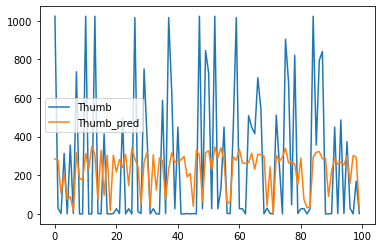

In [161]:
vis[['Thumb','Thumb_pred']].iloc[0:100].plot()

### Save the model and the scalers

In [25]:
import joblib

model_name = "NNBasic"

model.save(f"../models/{model_name}.h5")
# Save hand scaler to file.
# Scales the output of the network, the relative position of the hand, min_max
joblib.dump(rel_hand_scaler, f'../models/{model_name}-Hand.gz')

# Scales the input to the network, the emg data. 
joblib.dump(emg_scaler, f'../models/{model_name}-EMG.gz')

['../models/NNBasic-EMG.gz']

In [32]:
# Making a prediction in the prediction script.
from keras.models import load_model
model = load_model(f"../models/{model_name}.h5")

input_scaler = joblib.load(f'../models/{model_name}-EMG.gz')
output_scaler = joblib.load(f'../models/{model_name}-Hand.gz')

# Get some input data
semg_input = np.array([[ 31, 140, 140,  83,  42,  30,  22,  21]])
# Scale the input
scaled_input = input_scaler.transform(semg_input)
# Get a prediction
pred = model.predict(scaled_input)
# Scale it back to a value
scaled_pred = output_scaler.inverse_transform(pred)
scaled_pred
# Five finger, 4 joints + palm, wrist. x,y,z
NUM_POINTS = (5 * 4 + 2) * 3
pred_points = scaled_pred.reshape((3, NUM_POINTS//3))

In [34]:
prediction = model.predict(test_X) # scaled inputs here
print(prediction)

# Scaling back the prediction
preds = rel_hand_scaler.inverse_transform(prediction)
# Scaling back the goals
goal = rel_hand_scaler.inverse_transform(test_y)

MSE = mean_squared_error(goal, preds)  # first 2 steps, combined
print("MSE: ", MSE)
print("RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(goal, preds)
print("MAE: ", MAE)

[[-4.5049565e-06  1.3522451e-01  1.9394498e-01 ...  4.3251178e-01
   4.6078485e-01  4.7190204e-01]
 [-8.7510090e-04 -7.1135086e-01 -6.2075865e-01 ... -3.4064233e+00
  -3.3668852e+00 -3.1552842e+00]
 [-6.1699393e-05 -1.3594567e+00 -1.3763057e+00 ... -5.9100866e-02
  -4.8829131e-03  7.9832748e-03]
 ...
 [-5.8942282e-04  4.3737227e-01  4.4054431e-01 ...  8.8437259e-02
   4.2439986e-02  6.5242447e-02]
 [-5.8826065e-04  1.6924892e-01  1.9087942e-01 ...  2.6290509e-01
   2.7017626e-01  2.5774345e-01]
 [-6.7539624e-04 -6.0026234e-01 -6.1047447e-01 ... -5.8251113e-01
  -6.5339762e-01 -7.0003843e-01]]
MSE:  35.71878606050352
RMSE:  5.976519560789835
MAE:  3.439322011276025
